In [1]:
import csv

# Specify the CSV file's path
csv_file_path = '/kaggle/input/wikiart/wclasses.csv'

# Open and read the CSV file
with open(csv_file_path, mode='r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    count = 0
    for row in csv_reader:
        if count == 50:
            break
        print(', '.join(row))
        count += 1

file, artist, genre, style
Realism/vincent-van-gogh_pine-trees-in-the-fen-1884.jpg, 22, 133, 161
Baroque/rembrandt_the-angel-appearing-to-the-shepherds-1634.jpg, 20, 136, 144
Post_Impressionism/paul-cezanne_portrait-of-the-artist-s-son.jpg, 16, 135, 160
Impressionism/pierre-auguste-renoir_young-girl-seated-in-a-meadow-1916.jpg, 17, 131, 152
Romanticism/ivan-aivazovsky_morning-1851.jpg, 9, 139, 163
Art_Nouveau_Modern/boris-kustodiev_meeting-easter-day-1917.jpg, 1, 131, 143
Realism/vincent-van-gogh_vase-with-asters-and-phlox-1886.jpg, 22, 139, 161
Romanticism/ivan-aivazovsky_night-in-the-ukraine-1871.jpg, 9, 133, 163
Northern_Renaissance/albrecht-durer_deposition-engraved-passion-1512.jpg, 25, 136, 157
Realism/john-singer-sargent_leon-delafosse.jpg, 11, 135, 161
Romanticism/ivan-aivazovsky_rush-on-dnepr-near-aleshki-1857.jpg, 9, 133, 163
Symbolism/nicholas-roerich_patrol-1905.jpg, 14, 131, 164
Symbolism/nicholas-roerich_remember-1945.jpg, 14, 133, 164
Realism/boris-kustodiev_portrait-of-

In [3]:
import csv

# Specify the CSV file's path
csv_file_path = '/kaggle/input/-wikiart-all-images-120k-link/wikiart_scraped.csv'

# Open and read the CSV file
with open(csv_file_path, mode='r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    count = 0
    for row in csv_reader:
        #if count == 50:
        #    break
        #print(', '.join(row))
        if (row[2]=="Salvador Dali"):
            count += 1


In [3]:
import pandas as pd

# Load the dataset
classes_df = pd.read_csv('/kaggle/input/wikiart/classes.csv')

# Assuming 'artist' column has artist names and 'filename' has paths to the images
filtered_df = classes_df[(classes_df['genre'] == "['Cubism']")]
artist_data = ["/kaggle/input/wikiart/" + x for x in filtered_df['filename'].tolist()]
print(len(artist_data))


2002


In [5]:
import os

# Define the path to the folder
folder_path = '/kaggle/input/coco-2017-dataset/coco2017/test2017/'

# Get a list of all files in the folder
real_world_images_data_all = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]


In [6]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms

class ArtDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [8]:
real_world_images_data = real_world_images_data_all[:2000]
print(len(real_world_images_data))
print(len(artist_data))

2000
481


In [9]:
dataset_A = ArtDataset(artist_data, transform=transform)
dataset_B = ArtDataset(real_world_images_data, transform=transform)

loader_A = DataLoader(dataset_A, batch_size=4, shuffle=True)
loader_B = DataLoader(dataset_B, batch_size=4, shuffle=True)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(True)
            ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(True)
            ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)
    

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True)
        ]

        model += [
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128), 
            nn.LeakyReLU(0.2, True)
        ]

        model += [
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256), 
            nn.LeakyReLU(0.2, True)
        ]

        model += [
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512), 
            nn.LeakyReLU(0.2, True)
        ]

        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [3]:
# Hyperparameters
lr = 0.0002
betas = (0.5, 0.999)
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
# Models
G_X2Y = Generator(3, 3).to(device)
G_Y2X = Generator(3, 3).to(device)
D_X = Discriminator(3).to(device)
D_Y = Discriminator(3).to(device)

# Optimizers
optimizer_G = torch.optim.Adam(list(G_X2Y.parameters()) + list(G_Y2X.parameters()), lr=lr, betas=betas)
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=lr, betas=betas)
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=lr, betas=betas)

# Losses
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

In [6]:
!pip install torchview

In [10]:
from torchview import draw_graph
model_graph = draw_graph(ResidualBlock(64), input_size=(4,3,256, 256), expand_nested=True)
model_graph.visual_graph

RuntimeError: Failed to run torchgraph see error message

In [ ]:
lr = 0.00001
num_epochs = 50

# Training
# Create iterators for both loaders


for __ in range(num_epochs):
    iter_A = iter(loader_A)
    iter_B = iter(loader_B)
    
    total_loss_g = 0
    total_loss_identity = 0
    total_loss_GAN = 0
    total_loss_cycle = 0
    # Loop until the shortest dataset is exhausted
    for j in range(min(len(loader_A), len(loader_B))):

            images_A = next(iter_A).to(device)
            images_B = next(iter_B).to(device)

            # Generators X2Y and Y2X
            optimizer_G.zero_grad()

            # Identity loss
            loss_identity_X = criterion_identity(G_Y2X(images_A), images_A)
            loss_identity_Y = criterion_identity(G_X2Y(images_B), images_B)

            loss_identity = (loss_identity_X + loss_identity_Y) / 2

            # GAN loss
            fake_Y = G_X2Y(images_A)
            pred_fake_Y = D_Y(fake_Y)
            loss_GAN_X2Y = criterion_GAN(pred_fake_Y, torch.ones_like(pred_fake_Y))

            fake_X = G_Y2X(images_B)
            pred_fake_X = D_X(fake_X)
            loss_GAN_Y2X = criterion_GAN(pred_fake_X, torch.ones_like(pred_fake_X))

            loss_GAN = (loss_GAN_X2Y + loss_GAN_Y2X) / 2

            # Cycle loss
            recovered_X = G_Y2X(fake_Y)
            loss_cycle_X = criterion_cycle(recovered_X, images_A)

            recovered_Y = G_X2Y(fake_X)
            loss_cycle_Y = criterion_cycle(recovered_Y, images_B)

            loss_cycle = (loss_cycle_X + loss_cycle_Y) / 2

            # Total generator loss
            loss_G = loss_identity + loss_GAN * 4 + 10.0 * loss_cycle
            total_loss_g += loss_G.detach().cpu().item()
            total_loss_identity += loss_identity.detach().cpu().item()
            total_loss_GAN += loss_GAN.detach().cpu().item()
            total_loss_cycle += loss_cycle.detach().cpu().item()

            loss_G.backward()
            optimizer_G.step()

            # Discriminator X
            optimizer_D_X.zero_grad()
            pred_images_A = D_X(images_A)
            loss_D_images_A = criterion_GAN(pred_images_A, torch.ones_like(pred_images_A))

            pred_fake_X = D_X(fake_X.detach())
            loss_D_fake_X = criterion_GAN(pred_fake_X, torch.zeros_like(pred_fake_X))

            loss_D_X = (loss_D_images_A + loss_D_fake_X) / 2
            loss_D_X.backward()
            optimizer_D_X.step()

            # Discriminator Y
            optimizer_D_Y.zero_grad()
            pred_images_B = D_Y(images_B)
            loss_D_images_B = criterion_GAN(pred_images_B, torch.ones_like(pred_images_B))

            pred_fake_Y = D_Y(fake_Y.detach())
            loss_D_fake_Y = criterion_GAN(pred_fake_Y, torch.zeros_like(pred_fake_Y))

            loss_D_Y = (loss_D_images_B + loss_D_fake_Y) / 2
            loss_D_Y.backward()
            optimizer_D_Y.step()
            
    n = min(len(loader_A), len(loader_B))
    print("loss:", total_loss_g / n, 
                  "loss_identity:", total_loss_identity/ n,
                  "loss_GAN:", total_loss_GAN / n,
                  "loss_cycle:", total_loss_cycle/ n)



loss: 3.3007498851492385 loss_identity: 0.15473104526927647 loss_GAN: 0.4906089892072126 loss_cycle: 0.11835828946887954
loss: 3.13650597225536 loss_identity: 0.14956975389610638 loss_GAN: 0.4718352064859769 loss_cycle: 0.1099595404114605
loss: 3.1447720724689074 loss_identity: 0.14775948158719324 loss_GAN: 0.4723316995072956 loss_cycle: 0.11076857876186529
loss: 3.1932212301522247 loss_identity: 0.15366666382255634 loss_GAN: 0.4806410842690586 loss_cycle: 0.11169902370734648
loss: 3.1362584977110557 loss_identity: 0.15028630233993215 loss_GAN: 0.46522749775697375 loss_cycle: 0.11250621893189171
loss: 3.114297484563402 loss_identity: 0.14564464099643645 loss_GAN: 0.4703133904244289 loss_cycle: 0.10873992667217885
loss: 3.1903256365090362 loss_identity: 0.1503090211921487 loss_GAN: 0.4820251085541465 loss_cycle: 0.11119161952625621
loss: 3.2396200629305247 loss_identity: 0.15249264154059827 loss_GAN: 0.49162133074989006 loss_cycle: 0.1120642081888254
loss: 3.180146087299694 loss_identit

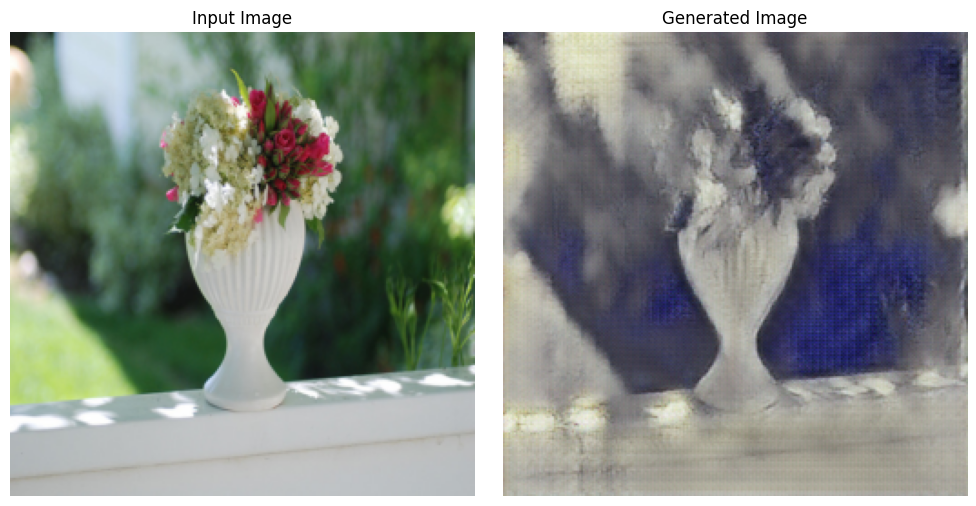

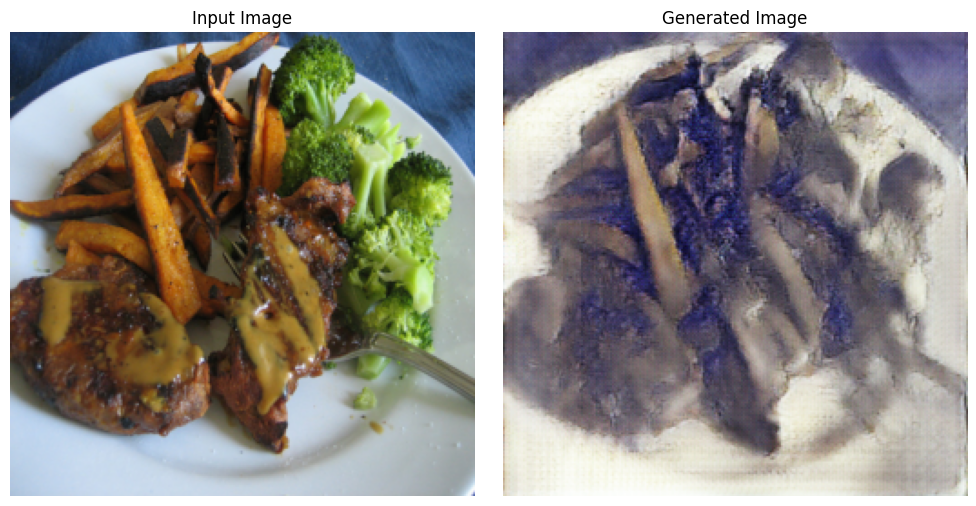

In [52]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def test_image(image_path, model, device, transform):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations and add batch dimension
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Generate the fake image
    with torch.no_grad():
        fake_image_tensor = model(image_tensor)

    # Convert tensors back to images for visualization
    fake_image = transforms.ToPILImage()(fake_image_tensor.squeeze().cpu() * 0.5 + 0.5)  # Denormalize if the model uses [-1, 1] range
    real_image = transforms.ToPILImage()(image_tensor.squeeze().cpu() * 0.5 + 0.5)     # Denormalize if the model uses [-1, 1] range

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(real_image)
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    ax[1].imshow(fake_image)
    ax[1].set_title("Generated Image")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

# Test with an image
test_image('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000030.jpg', G_Y2X, device, transform)
test_image('/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000161.jpg', G_Y2X, device, transform)


In [48]:
# Save model weights
torch.save({
    'G_X2Y': G_X2Y.state_dict(),
    'G_Y2X': G_Y2X.state_dict(),
    'D_X': D_X.state_dict(),
    'D_Y': D_Y.state_dict(),
}, '/kaggle/working/weights.pth')

In [25]:
checkpoint = torch.load('/kaggle/working/datatatataweights2.pth')
G_X2Y.load_state_dict(checkpoint['G_X2Y'])
G_Y2X.load_state_dict(checkpoint['G_Y2X'])
D_X.load_state_dict(checkpoint['D_X'])
D_Y.load_state_dict(checkpoint['D_Y'])

<All keys matched successfully>

In [44]:
print(artist_data[4])
print(artist_data[42])

/kaggle/input/wikiart/Abstract_Expressionism/salvador-dali_christ-from-the-apocalypse-of-st-john.jpg
/kaggle/input/wikiart/Cubism/salvador-dali_still-life-by-moonlight.jpg


Text(0.5, 1.0, 'Input Image')

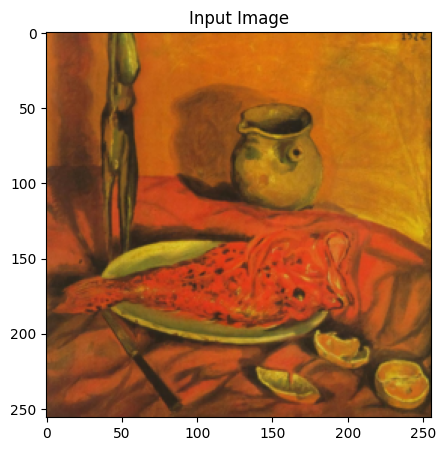

In [53]:

fig, ax = plt.subplots(1, figsize=(10, 5))


image = Image.open(artist_data[98]).convert('RGB')

# Apply transformations and add batch dimension
image_tensor = transform(image).unsqueeze(0).to(device)

# Convert tensors back to images for visualization
image = transforms.ToPILImage()(image_tensor.squeeze().cpu() * 0.5 + 0.5)

ax.imshow(image)
ax.set_title("Input Image")